# Libraries

In [1]:
import pandas as pd

import regex as re

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import pyLDAvis
import pyLDAvis.gensim_models as gensim_models
import pyLDAvis.gensim_models as gensimvis


import gensim
# from gensim.models import wrappers
# from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD


import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer


from pprint import pprint

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

/Users/austinboring/opt/anaconda3/envs/broke-the-other/lib/python3.10/site-packages/gensim/matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu


# Importing -- Fixing columns

In [2]:
full = pd.read_csv('Data/Data-Cleaned/238k-Uncleaned')

In [3]:
# Renaming tweets column, dropping unnamed column, making tweets strings

full['tweets'] = full['0']
full = full.drop(columns = '0')

# Preprocessing

In [4]:
def Series_Preprocessor(tweet):
    stopWords = stopwords.words('english')
    stopWords.extend(['tesla', 'c,', 'x', 't', 'p', 'amp'])
    ps = PorterStemmer()
    wnl = WordNetLemmatizer()

        # helper function to change nltk's part of speech tagging to a wordnet format.
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None 
    
#   Lowercase all 
    tweet = tweet.lower()
    
#   Removing @ handles, links-- strip whitespace breaks and tabs
    tweet = re.sub(r"@\w+|http\S+", "", tweet).strip().replace("\r", "").replace("\n", "").replace("\t", "")
    
#   Tokenize,make list of words, removing punctuation and stopwords
    tweet = [x for x in word_tokenize(tweet) if ((x.isalpha()) & (x not in stopWords)) ]
    
#   Map part of speech tags to words and use words/tags to lemmatize accuratley
    tweet = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(tweet))) 
    tweet = " ".join([wnl.lemmatize(x[0], x[1]) for x in tweet if x[1] is not None])

    return tweet 

In [5]:
df = full['tweets'].apply(Series_Preprocessor)

In [6]:
df['tokens'] = [i.split() for i in df]

In [7]:
# Dictionary is a gensim tool
id2word = Dictionary(df['tokens'])
print(len(id2word)) 

44577


In [8]:
# id2word.filter_extremes(no_below=4, no_above=.95) #Original -- 12656
id2word.filter_extremes(no_below=6, no_above=.90)
print(len(id2word))

14944


In [9]:
corpus = [id2word.doc2bow(d) for d in df['tokens']]

## LdaMulticore -------------------------

In [10]:
# Instantiating a Base LDA model
base_model = LdaMulticore(corpus=corpus, num_topics=5, id2word=id2word, workers=12, passes=5)

In [11]:
# Filtering for words 
words = [re.findall(r'"([^"]*)"',t[1]) for t in base_model.print_topics()]
# Create Topics
topics = [' '.join(t[0:10]) for t in words]
# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Topic {id + 1} ------")
    print(t, end="\n\n")

------ Topic 1 ------
esg model index spot first state musk teslaradar elon car

------ Topic 2 ------
car electric make battery ev drive fire company get go

------ Topic 3 ------
musk elon buy get never say know company think free

------ Topic 4 ------
stock buy car go price electric get market share sell

------ Topic 5 ------
car crash stock door people get driver autopilot lock know



In [12]:
# a measure of how good the model is. lower the better
base_perplexity = base_model.log_perplexity(corpus)

# Compute Coherence Score
coherence_model = CoherenceModel(model=base_model, texts=df['tokens'], 
                                   dictionary=id2word, coherence='c_v')

coherence_lda_model_base = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence_lda_model_base, '\n\nPerplexity: ', base_perplexity)


Coherence Score:  0.3114568677215039 

Perplexity:  -7.579058502383119


In [13]:
#Creating Topic Distance Visualization 
pyLDAvis.enable_notebook()

In [14]:
gensimvis.prepare(base_model, corpus, id2word)

/Users/austinboring/opt/anaconda3/envs/broke-the-other/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Users/austinboring/opt/anaconda3/envs/broke-the-other/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Users/austinboring/opt/anaconda3/envs/broke-the-other/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Users/austinboring/opt/anaconda3/envs/broke-the-other/lib/python3.10/site-packages/past/builtins/misc.py:

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.070640 -0.018159       1        1  32.742230
3      0.087835  0.044182       2        1  21.152233
2      0.020200  0.131455       3        1  20.755821
4      0.051099 -0.147532       4        1  14.302926
0     -0.229775 -0.009946       5        1  11.046791, topic_info=       Term          Freq         Total Category  logprob  loglift
151   stock  24495.000000  24495.000000  Default  30.0000  30.0000
157    elon  18083.000000  18083.000000  Default  29.0000  29.0000
126    musk  20179.000000  20179.000000  Default  28.0000  28.0000
203     esg   5793.000000   5793.000000  Default  27.0000  27.0000
144     buy  25893.000000  25893.000000  Default  26.0000  26.0000
...     ...           ...           ...      ...      ...      ...
79      car   2240.410295  63168.464974   Topic5  -4.8584  -1.1361
64      get   1644.573839  23365.304421   Topic5  -5.1676  -0.4507
1239    fsd   1138.830354   3654.581228   Topic5  -5.5351   1.0371
190    make   1371.448407  19488.537705   Topic5  -5.3492  -0.4509
59     tsla   1213.081201   6555.512218   Topic5  -5.4719   0.5159

[473 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1467      3  0.986044  accenture
1605      1  0.160362   accident
1605      2  0.003467   accident
1605      3  0.062411   accident
1605      4  0.732465   accident
...     ...       ...        ...
352       1  0.476311       year
352       2  0.289665       year
352       3  0.119285       year
352       4  0.057069       year
352       5  0.057804       year

[1411 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 5, 1])

# Word Clouds

In [15]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# mapping real words to their respective weights in each topic
def get_topic_words(topic_num, num_words):
    id_freq = base_model.get_topic_terms(topic_num, topn= num_words)
    topic_words = {}
    for word in id_freq:
        topic_words[id2word[word[0]]] = word[1]
    return topic_words

def make_wordcloud(topic_dict):
    wc = WordCloud(background_color = 'white')
    wc.generate_from_frequencies(topic_dict)
    plt.imshow(wc, interpolation = 'bilinear')
    plt.axis('off')
    plt.show()

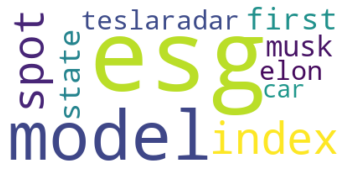

In [16]:
make_wordcloud(get_topic_words(0, 10))